# PennyLane Quantum Neural Network (QNN) for MNIST Binary Classification

This notebook implements a QNN using PennyLane to classify handwritten digits 0 and 1 from the MNIST dataset.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pennylane as qml

# Device and parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
size = 16
n_qubits = 8
n_layers = 4
batch_size = 16
epochs = 5

In [2]:
# Dataset loading
def load_dataset(name="MNIST"):
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])
    if name == "MNIST":
        train = datasets.MNIST(root="MNIST", train=True, download=True, transform=transform)
        test = datasets.MNIST(root="MNIST", train=False, download=True, transform=transform)
    return train, test

def generate_subset(dataset):
    return [(x, torch.tensor(y, dtype=torch.float32)) for x, y in dataset if y in [0, 1]]

train_raw, test_raw = load_dataset("MNIST")
train_dataset = generate_subset(train_raw)
test_dataset = generate_subset(test_raw)

# PennyLane device
dev = qml.device("default.qubit", wires=n_qubits)

In [3]:
# Quantum circuit definition
def layer(weights):
    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

def qnode_fn(inputs, weights):
    qml.templates.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    for l in range(n_layers):
        layer(weights[l])
    return qml.expval(qml.PauliZ(n_qubits - 1))

qnode = qml.QNode(qnode_fn, dev, interface="torch")

In [4]:
# Torch wrapper
class TorchQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(0.01 * torch.randn(n_layers, n_qubits))

    def forward(self, x):
        x = x.view(-1, size * size)
        x = x / torch.norm(x, dim=1, keepdim=True)  # normalize
        outputs = [ qnode(x[i], self.weights) for i in range(x.shape[0]) ]
        return torch.stack(outputs).to(device)

In [5]:
# Evaluation
def evaluate(model, dataset, name):
    model.eval()
    correct, total = 0, 0
    loss_fn = nn.BCEWithLogitsLoss()
    loss_val = 0
    loader = DataLoader(dataset, batch_size=batch_size)
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            y = y.to(device).to(torch.float32)
            pred = model(X)
            loss_val += loss_fn(pred, y).item()
            pred_label = torch.stack([1 - pred, pred], dim=1).argmax(1)
            correct += (pred_label == y).sum().item()
            total += y.size(0)
    print(f"{name} Accuracy: {correct/total:.3f}, Loss: {loss_val/len(loader):.3f}")

In [6]:
# Training function
def train(model, train_dataset, test_dataset):
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(epochs):
        model.train()
        loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        for batch, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            X = X.to(torch.float32)
            y = y.to(device).float()
            pred = model(X)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch % 20 == 0:
                print(f"Epoch {epoch+1}, Batch {batch}, Loss: {loss.item():.4f}")

        evaluate(model, train_dataset, 'Train')
        evaluate(model, test_dataset, 'Test')

## 학습 시작


Epoch 1, Batch 0, Loss: 0.6927
Epoch 1, Batch 20, Loss: 0.6908
Epoch 1, Batch 40, Loss: 0.6891
Epoch 1, Batch 60, Loss: 0.6872
Epoch 1, Batch 80, Loss: 0.6866
Epoch 1, Batch 100, Loss: 0.6839
Epoch 1, Batch 120, Loss: 0.6824
Epoch 1, Batch 140, Loss: 0.6723
Epoch 1, Batch 160, Loss: 0.6639
Epoch 1, Batch 180, Loss: 0.6531
Epoch 1, Batch 200, Loss: 0.6496
Epoch 1, Batch 220, Loss: 0.6437
Epoch 1, Batch 240, Loss: 0.6487
Epoch 1, Batch 260, Loss: 0.6269
Epoch 1, Batch 280, Loss: 0.6129
Epoch 1, Batch 300, Loss: 0.6267
Epoch 1, Batch 320, Loss: 0.5938
Epoch 1, Batch 340, Loss: 0.6166
Epoch 1, Batch 360, Loss: 0.5968
Epoch 1, Batch 380, Loss: 0.5948
Epoch 1, Batch 400, Loss: 0.5777
Epoch 1, Batch 420, Loss: 0.5979
Epoch 1, Batch 440, Loss: 0.5652
Epoch 1, Batch 460, Loss: 0.5568
Epoch 1, Batch 480, Loss: 0.5946
Epoch 1, Batch 500, Loss: 0.5969
Epoch 1, Batch 520, Loss: 0.5916
Epoch 1, Batch 540, Loss: 0.5799
Epoch 1, Batch 560, Loss: 0.6056
Epoch 1, Batch 580, Loss: 0.5676
Epoch 1, Batch 6

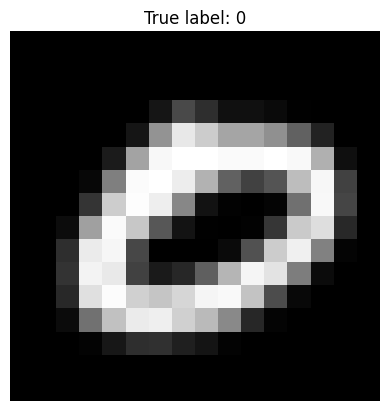

Predicted label: 0


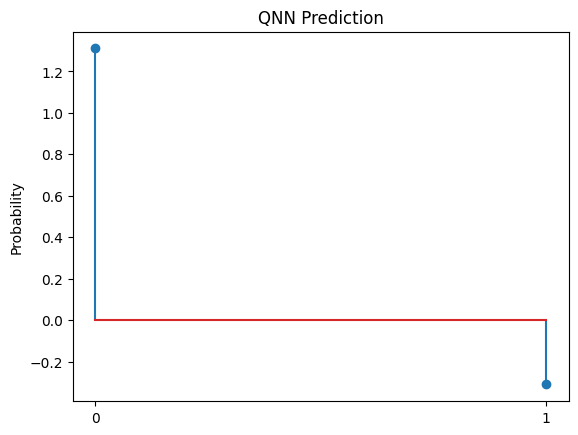

In [7]:
# Run
model = TorchQNN().to(device)
train(model, train_dataset, test_dataset)

# Predict single sample
model.eval()
import random
idx = random.randint(0, len(test_dataset) - 1)
x = test_dataset[idx][0]
y_true = test_dataset[idx][1].item()

plt.imshow(x[0], cmap='gray')
plt.title(f"True label: {int(y_true)}")
plt.axis('off')
plt.show()

with torch.no_grad():
    out = model(x.view(1, 1, size, size)).cpu().numpy()[0]
    prob = [1 - out, out]
    pred = np.argmax(prob)
    print(f'Predicted label: {pred}')
    plt.stem([0, 1], prob)
    plt.xticks([0, 1])
    plt.ylabel('Probability')
    plt.title('QNN Prediction')
    plt.show()

## 모델 저장


In [8]:
# 모델 저장
model_path = "torchqnn_mnist.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to: {model_path}")

✅ Model saved to: torchqnn_mnist.pth


## 모델 로딩, 평가


In [ ]:
# 새로운 모델 객체 생성
model = TorchQNN().to(device)

# 저장된 파라미터 불러오기
model.load_state_dict(torch.load("torchqnn_mnist.pth"))
model.eval()  # 평가 모드로 전환

print("✅ Model loaded and ready for inference.")

In [ ]:

# ✅ Load and continue training

# 1. 모델 객체 생성
model = TorchQNN().to(device)

# 2. 저장된 파라미터 불러오기
model.load_state_dict(torch.load("torchqnn_mnist.pth"))
model.train()  # 학습 모드로 전환

# 3. 옵티마이저 & Loss 재설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

# 4. 이어서 학습
train(model, train_dataset, test_dataset)


Epoch 1, Batch 0, Loss: 0.5319
Epoch 1, Batch 20, Loss: 0.5592
Epoch 1, Batch 40, Loss: 0.5410
Epoch 1, Batch 60, Loss: 0.5118
Epoch 1, Batch 80, Loss: 0.5580
Epoch 1, Batch 100, Loss: 0.5443
Epoch 1, Batch 120, Loss: 0.5447
Epoch 1, Batch 140, Loss: 0.5244
Epoch 1, Batch 160, Loss: 0.5301
Epoch 1, Batch 180, Loss: 0.5246
Epoch 1, Batch 200, Loss: 0.5256
Epoch 1, Batch 220, Loss: 0.5084
Epoch 1, Batch 240, Loss: 0.5732
Epoch 1, Batch 260, Loss: 0.5439
Epoch 1, Batch 280, Loss: 0.5365
Epoch 1, Batch 300, Loss: 0.5549
Epoch 1, Batch 320, Loss: 0.5338
Epoch 1, Batch 340, Loss: 0.5199
Epoch 1, Batch 360, Loss: 0.5094
Epoch 1, Batch 380, Loss: 0.5478
Epoch 1, Batch 400, Loss: 0.5495
Epoch 1, Batch 420, Loss: 0.5126
Epoch 1, Batch 440, Loss: 0.5318
Epoch 1, Batch 460, Loss: 0.5322
Epoch 1, Batch 480, Loss: 0.5363
Epoch 1, Batch 500, Loss: 0.5164
Epoch 1, Batch 520, Loss: 0.5277
Epoch 1, Batch 540, Loss: 0.5173
Epoch 1, Batch 560, Loss: 0.5101
Epoch 1, Batch 580, Loss: 0.5558
Epoch 1, Batch 6